## 문제정의
- 은행에서 대출상환불이행을 제대로 예측하지 못하여 손해가 발생하고 있어 분류모델을 통해 대출하지 않아야 할 케이스를 제대로 분류하고 싶은 니즈가 있음.
- 추가적으로, 대출 상품을 어떠한 특성을 가진 고객에게 맞추어 구성을 해야하는지 파악하고자 함.

## 프로젝트의 목표
1. 대출금 상환불이행으로 인한 손해를 낮추는 분류 모델을 설계한다.
2. 대출 상품 마케팅 전략을 수립하기 위해 상환불이행에 영향을 미치는 변수를 확인한다.

## 예상산출물
* 분류 모델 (평가지표: f1-score, accuray)
* 모델에 영향을 미치는 변수들의 순위 및 정도

## 대상 데이터
* 데이터명:'Loan Prediction Based on Customer Behavior' 
* 출처: https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior?resource=download
* 데이터 정보:
  * 설명변수: 대출고객고유식별자('Id'), 소득('Income'), 나이('Age'),총경력('Experience'), 결혼여부('Married/Single'), 자가여부('House_Ownership'), 자가용소유여부('Car_Ownership'), 직업('Profession'), 도시('CITY'), 주('STATE'), 현직업경력년수('CURRENT_JOB_YRS'), 현주택보유년수('CURRENT_HOUSE_YRS')
  * 종속변수(타겟): 대출불이행여부('Risk_Flag'
  * 관찰값 수: 

## 평가지표: f1-score, auc_roc
* 대출을 해주지 않아야 할 건에 대해 대출을 해준 경우를 줄여야 하기 때문에, 이는 2종 오류를 줄이는 것으로 가늠됨.
* 2종 오류를 줄이는 것이 중요하기 때문에 평가 지표로는 정밀도(Precision)와 재현율(Recall)이 좋으나, 두 지표는 서로 반비례 관계에 있으므로 정밀도와 재현율을 모두 고려할 수 있는 F1 score나, 이들의 가중 조화평균인 AUC-ROC(Area Under the Receiver Operating Characteristic curve)를 평가 지표로 사용하는 것이 좋음.

## 가설 설정
* 가설: 여러 변수(소득, 나이, 총경력, 결혼여부, 자가여부, 자가용소유여부, 직업, 현직업경력년수 등)에 따라 대출상환 불이행 여부가 정해질 것이다.

# Load data

In [ ]:
!pip install category_encoders
!pip3 install eli5
!pip install scikit-learn==1.1.3
!pip install shap

In [ ]:
import pandas as pd
 
train = pd.read_csv('/content/Training Data.csv')
test = pd.read_csv('/content/Test Data.csv')

# 널값 체크
display(train.isna().sum())
# 결론: 뭐 할건 없다

display(train.describe(include="all").T)

display(train.dtypes)

# 모델의 일반화 향상을 위해 'Id', 'CITY', 'STATE' 변수 제거
# 'Id' 변수는 고유한 식별자로서 분석에 직접적으로 영향을 미치지 않으므로, 이 변수를 제거해도 모델의 성능에 영향을 미치지 않음
# 'CITY'와 'STATE' 변수는 지리적 정보를 나타내는 변수로 이러한 지리적 정보는 모델의 일반화 능력을 약화시키며, 이러한 변수를 제거하여 모델이 지역에 구애받지 않고 일반화될 수 있도록 하는 것이 좋음
train.drop(['Id', 'CITY', 'STATE'],axis=1,inplace=True)
test.drop(['ID', 'CITY', 'STATE'],axis=1,inplace=True)

# EDA  및 전처리

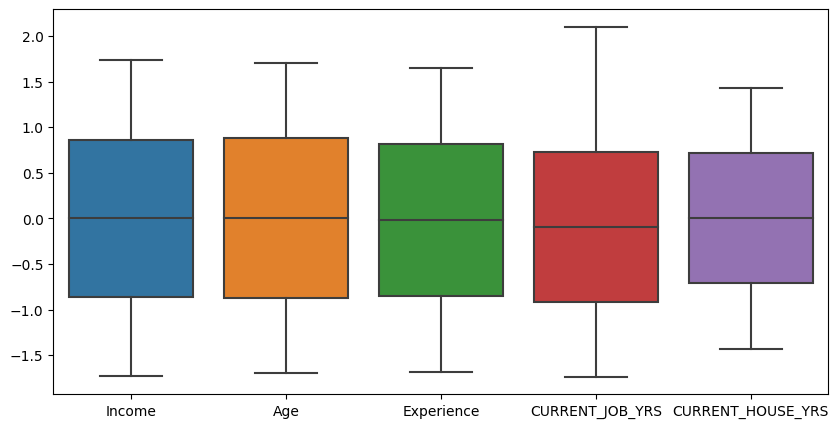

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


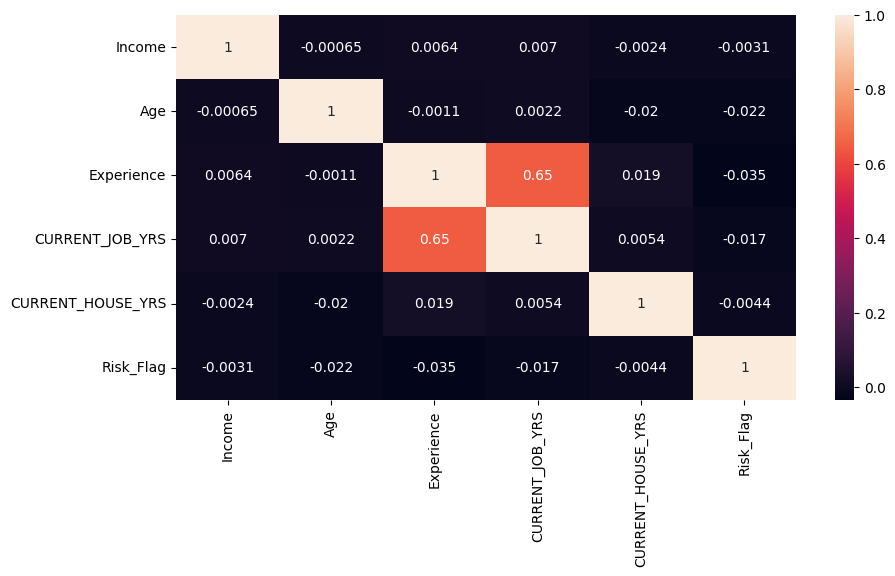

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

variables = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(train[variables])
scaled_df = pd.DataFrame(scaled_data, columns=variables)

plt.figure(figsize=(10,5))
sns.boxplot(data=scaled_df[variables])
plt.show()

# 결론: No outliers

plt.figure(figsize=(10,5))
sns.heatmap(train.corr(), annot=True);
plt.show()
# 결론: 과적합(overfitting)을 방지하기 위해서 상관관계가 높은 CURRENT_JOB_YRS 또는 Experience 둘 중 하나만 사용하는 것이 좋음
# 이유: 각각의 변수가 독립적인 정보를 제공하지 않고, 중복되는 정보를 포함히면 모델은 동일한 정보를 중복해서 사용하게 되어, 과적합을 유발할 수 있기 때문
# CURRENT_JOB_YRS을 제거하기로 결정
train.drop(['CURRENT_JOB_YRS'],axis=1,inplace=True)
test.drop(['CURRENT_JOB_YRS'],axis=1,inplace=True)

## 피쳐엔지니어링

In [ ]:
# 잔여평생기대소득 
# 잔여평생기대소득 = ((정년 나이 - 현재 나이) x 연간 현재 소득) + (예상수명 - 정년 나이 - 현재 나이) x 연간 현재 소득
def calc_eli(age, retire_age, curr_inc, life_expectancy):
    remaining_work_yrs = retire_age - age
    retire_inc = 0.4 * curr_inc
    reli = (remaining_work_yrs * curr_inc) + ((life_expectancy - remaining_work_yrs) * retire_inc)
    return reli

retire_age = 65
life_expectancy = 85
train['reli'] = train.apply(lambda x: calc_eli(x['Age'], retire_age, x['Income'], life_expectancy), axis=1)
test['reli'] = test.apply(lambda x: calc_eli(x['Age'], retire_age, x['Income'], life_expectancy), axis=1)

# 현추정자산
# 현추정자산 = 경력 * 현소득
def estimated_asset(income, experience):
  est_asset = income * experience
  return est_asset

train['est_asset'] = train.apply(lambda x: estimated_asset(x['Income'], x['Experience']), axis=1)
test['est_asset'] = test.apply(lambda x: estimated_asset(x['Income'], x['Experience']), axis=1)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


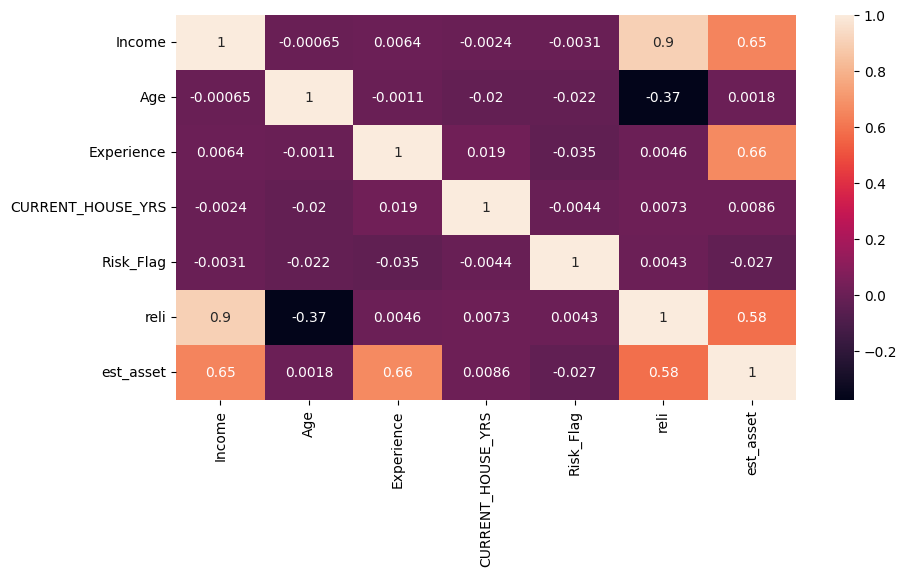

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


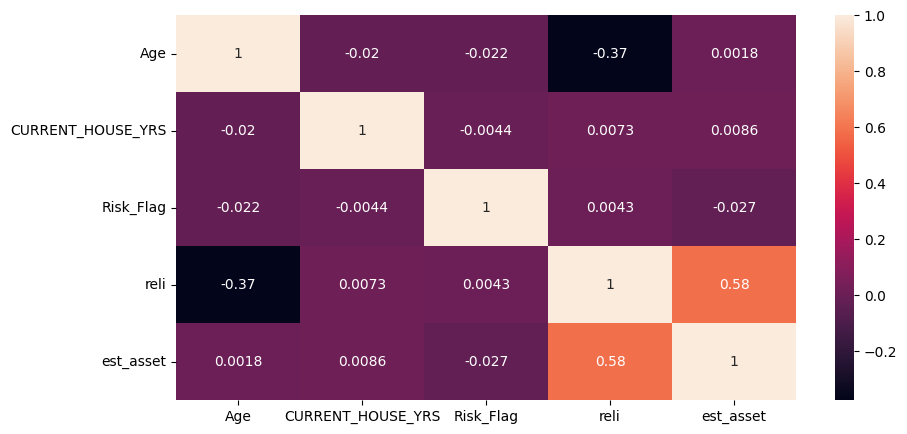

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(), annot=True);
plt.show()

# 결론: Income과 reli, Income과 est_asset간 강한 상관관계가 보이기 때문에 Income 변수 제거 결정
# 또한, Experience와 est_asset간 강한 상관관계가 보이기 때문에 Experience와 변수 제거 결정
train.drop(['Income', 'Experience'],axis=1,inplace=True)
test.drop(['Income', 'Experience'],axis=1,inplace=True)
# 일부 변수 제거 후 corr heatmap
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(), annot=True);
plt.show()

Baseline Accuracy: 0.877


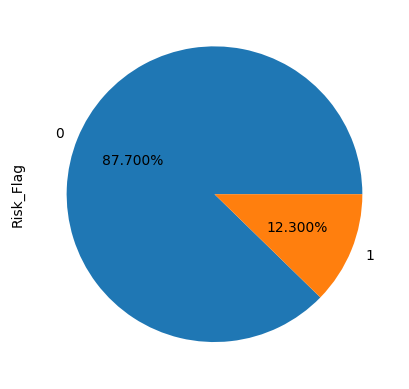

In [ ]:
# 타겟 분포 확인
target = "Risk_Flag"
train[target].value_counts(normalize=True).plot.pie(autopct="%.3f%%")
print("Baseline Accuracy:", train[target].value_counts(normalize=True).max())
# 결론: 클래스 불균형 문제 발생! 뭐든 해줄 것

## 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
print(train.shape, val.shape)

X_train, y_train = train.drop(columns=[target]), train[target]
X_val, y_val = val.drop(columns=[target]), val[target]

(201600, 9) (50400, 9)


## Encoding

In [ ]:
X_train_original = X_train.copy()
X_val_original = X_val.copy()

cat_cols = ["Married/Single", "House_Ownership", "Car_Ownership", "Profession"]

encoder = LabelEncoder()

for col in cat_cols:
  X_train[col] = encoder.fit_transform(X_train[col])
  X_val[col] = encoder.fit_transform(X_val[col])

## 클래스 불균형 처리

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# 클래스 불균형 비율 계산
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes=np.unique(y_train),
    y = y_train)

# 모델링

## Baseline 모델

Accuracy: 0.8770
Precision: 1.0000
Recall: 0.0000
F1: 0.0000
[[44201     0]
 [ 6199     0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       1.00      0.00      0.00      6199

    accuracy                           0.88     50400
   macro avg       0.94      0.50      0.47     50400
weighted avg       0.89      0.88      0.82     50400



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, 'Confusion Matrix (n = 50400)')

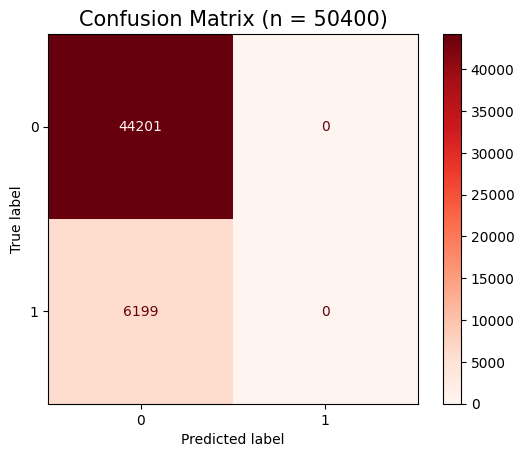

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# majority로 예측하는 더미 분류기 생성
baseline_model = DummyClassifier(strategy='most_frequent')

# 학습
baseline_model.fit(X_train, y_train)

# 예측
y_pred = baseline_model.predict(X_val)

# 성능 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred,  zero_division=1)
f1 = f1_score(y_val, y_pred,  zero_division=1)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1: {:.4f}'.format(f1))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, zero_division=1))

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(baseline_model, X_val, y_val, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_val)})", fontsize=15)

## XGBClassifier 모델 (LabelEncoder + class_weight 적용)

### 1차: Best estimator를 찾기 위한 여정 - 하이퍼파라미터 튜닝

In [ ]:
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder
from sklearn.metrics import auc, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 모델 생성
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=class_weights[1] / class_weights[0],

)

# 범주형 변수 컬럼 선택
cat_cols = ["Married/Single", "House_Ownership", "Car_Ownership", "Profession"]

watchlist = [(X_val, y_val)]

# 모델 학습
xgb.fit(
    X_train,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
    verbose=1
)

# 하이퍼파라미터 튜닝
hyperparameters = {
    'n_estimators': [200],
    'max_depth': [10, 16],
    'learning_rate': [0.10, 0.15],
}

grid_search = GridSearchCV(xgb, 
                           param_grid=hyperparameters,
                           cv=5,
                           scoring='f1', 
                           verbose=3)
grid_search.fit(X_train, y_train)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-auc:0.59354
[1]	validation_0-auc:0.61480
[2]	validation_0-auc:0.62978
[3]	validation_0-auc:0.65579
[4]	validation_0-auc:0.66566
[5]	validation_0-auc:0.67379
[6]	validation_0-auc:0.68054
[7]	validation_0-auc:0.69047
[8]	validation_0-auc:0.70067
[9]	validation_0-auc:0.70739
[10]	validation_0-auc:0.71481
[11]	validation_0-auc:0.71969
[12]	validation_0-auc:0.72686
[13]	validation_0-auc:0.72806
[14]	validation_0-auc:0.72874
[15]	validation_0-auc:0.72930
[16]	validation_0-auc:0.73639
[17]	validation_0-auc:0.74557
[18]	validation_0-auc:0.75051
[19]	validation_0-auc:0.75130
[20]	validation_0-auc:0.75509
[21]	validation_0-auc:0.76210
[22]	validation_0-auc:0.76599
[23]	validation_0-auc:0.77299
[24]	validation_0-auc:0.77728
[25]	validation_0-auc:0.77814
[26]	validation_0-auc:0.77955
[27]	validation_0-auc:0.77957
[28]	validation_0-auc:0.78209
[29]	validation_0-auc:0.78308
[30]	validation_0-auc:0.78409
[31]	validation_0-auc:0.78900
[32]	validation_0-auc:0.79151
[33]	validation_0-au

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.15], 'max_depth': [10, 16],
                         'n_estimators': [200]},
             scoring='f1', verbose=3)

### 2차: 하이퍼 파라미터 튜닝 결과값으로 다시 한번 모델 학습

In [ ]:
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

### 모델 평가

ROC AUC Score: 0.929640113683988
[[39904  4297]
 [ 1361  4838]]
검증 정확도 0.8877380952380952
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     44201
           1       0.53      0.78      0.63      6199

    accuracy                           0.89     50400
   macro avg       0.75      0.84      0.78     50400
weighted avg       0.91      0.89      0.90     50400



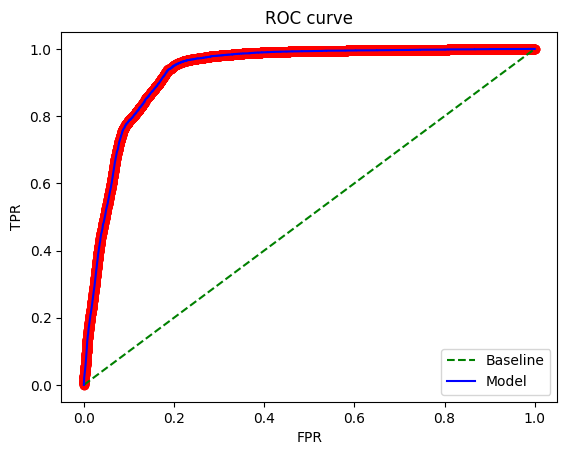

In [ ]:
# ROC AUC Score 확인
y_prob = best_xgb.predict_proba(X_val)[:,1]
roc_auc = roc_auc_score(y_val, y_prob)

y_pred = best_xgb.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

print("ROC AUC Score:", roc_auc)
print(cm)

print("검증 정확도", best_xgb.score(X_val, y_val))

# f1-score 확인
print(classification_report(y_val, y_pred))

baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds': thresholds})
plt.plot(baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline"
)
plt.plot(fpr, tpr, color="blue", label="Model")
plt.scatter(fpr, tpr, color="red")
plt.legend()
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, 'Confusion Matrix (n = 50400)')

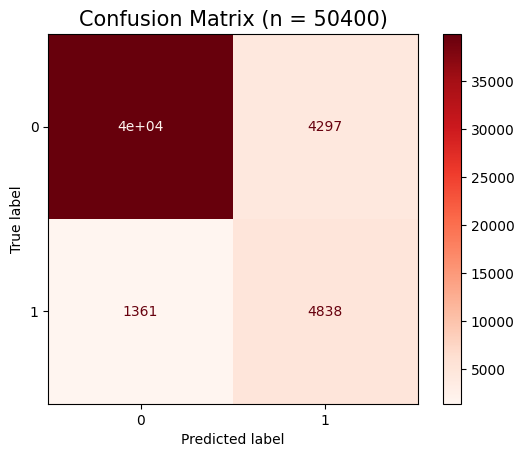

In [ ]:
# 혼동 행렬 확인
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_xgb, X_val, y_val, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_val)})", fontsize=15)


### 변수 중요도 확인 후 불필요 변수 제거

<Axes: >

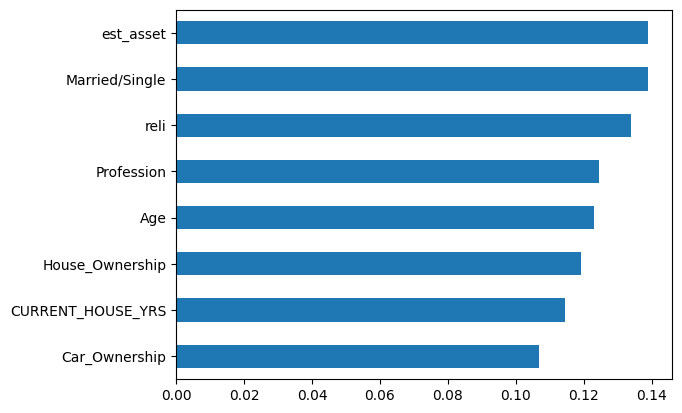

In [ ]:
importances = pd.Series(best_xgb.feature_importances_, X_train.columns)
importances.sort_values().plot.barh()

Text(0.5, 1.0, 'Permutation Importance')

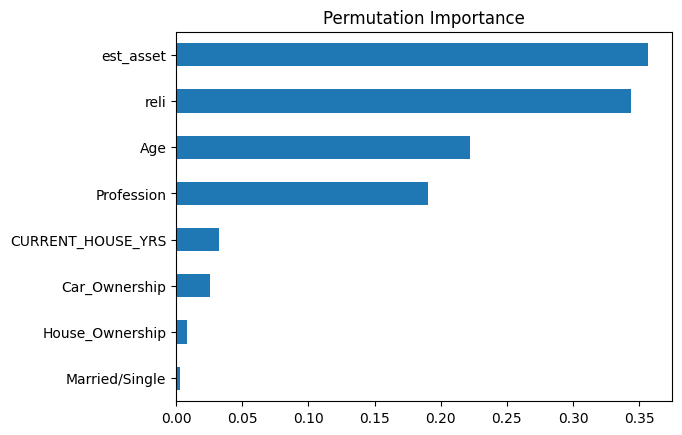

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    best_xgb,  # model
    scoring="f1",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

# 스코어를 다시 계산합니다.
# X_val_preprocessed = model[0].transform(X_val)
permuter.fit(X_val, y_val)

feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

In [ ]:
# 특성별 score을 확인합니다.
eli5.show_weights(
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.3570 ± 0.0115,est_asset
0.3437 ± 0.0091,reli
0.2218 ± 0.0088,Age
0.1903 ± 0.0092,Profession
0.0323 ± 0.0056,CURRENT_HOUSE_YRS
0.0255 ± 0.0039,Car_Ownership
0.0081 ± 0.0025,House_Ownership
0.0026 ± 0.0010,Married/Single


In [ ]:
# 결론: 'Married/Single', 'House_Ownership' 변수는 모델의 성능을 위해 제거하기로 함
X_train.drop(['Married/Single', 'House_Ownership'],axis=1,inplace=True)
X_val.drop(['Married/Single', 'House_Ownership'],axis=1,inplace=True)
X_train_original.drop(['Married/Single', 'House_Ownership'],axis=1,inplace=True)
X_val_original.drop(['Married/Single', 'House_Ownership'],axis=1,inplace=True)

### 최종 모델 학습

In [ ]:
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

# 모델 해석

## SHAP

In [ ]:
# xgboost.plot_importance(best_xgb)
X = X_val
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
X_display = X_val_original
shap.initjs()
i = 7
shap.force_plot(explainer.expected_value, shap_values[i,:], X_display.iloc[i,:])


In [ ]:
X_display = X_val_original
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:2000,:], X_display.iloc[:2000,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


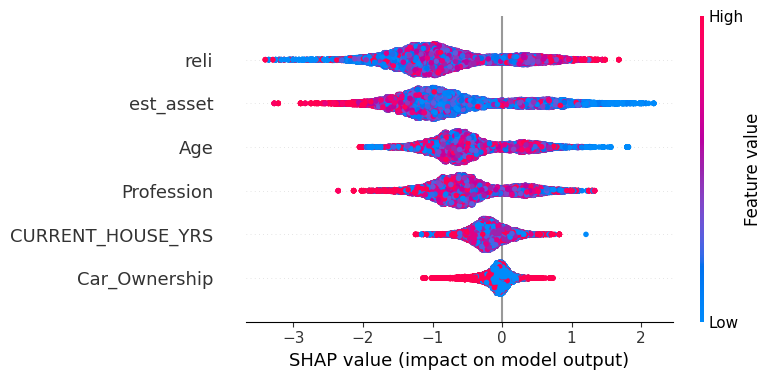

In [ ]:
shap.summary_plot(shap_values, X)

## 해석
* reli: 변수의 값이 높을 수록(빨간색(+)이 SHAP VALUE 양의 값에 많이 위치 할수록), 대출상환 불이행 가능성이 높은 경향이 있다.
  * 잔여평생기대소득이 
높을 수록, 대출상환 불이행 가능성이 다.
* est_asset: 변수의 값이 높을 수록(빨간색(+)이 SHAP VALUE 음의 값에 많이 위치 할수록), 대출상환 불이행 가능성이 낮은 경향이 있다.
  * 현추정자산이 많을 수록, 대출상환 불이행 가능성이 낮다.
* Age: 해석모호성
* profession: 해석모호성
* CURRENT_HOUSE_YRS: 해석모호성.
* Car_Ownership: 해석모호성


In [ ]:
import  xgboost

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_val, label=y_val)
params = best_xgb.get_xgb_params()
model_ind = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X_val[:1000])

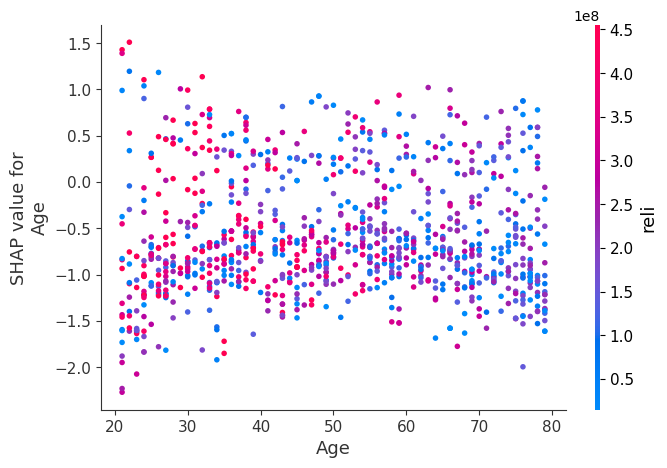

In [ ]:
shap.dependence_plot('Age', shap_values_ind, X[:1000], display_features=X_display)

In [ ]:
shap.initjs()
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind, X_val[:1000], display_features=X_display[:1000])

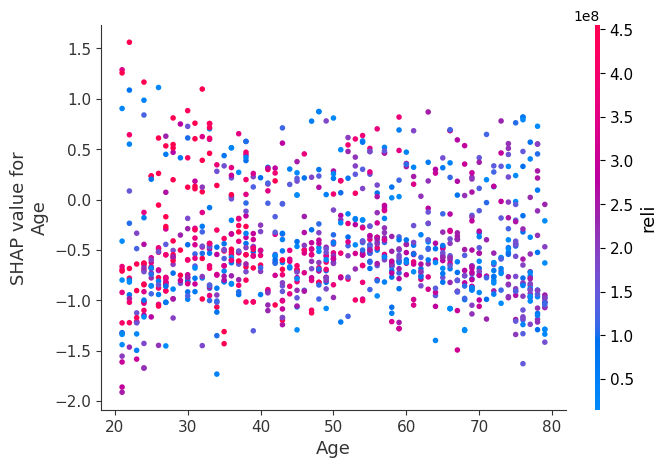

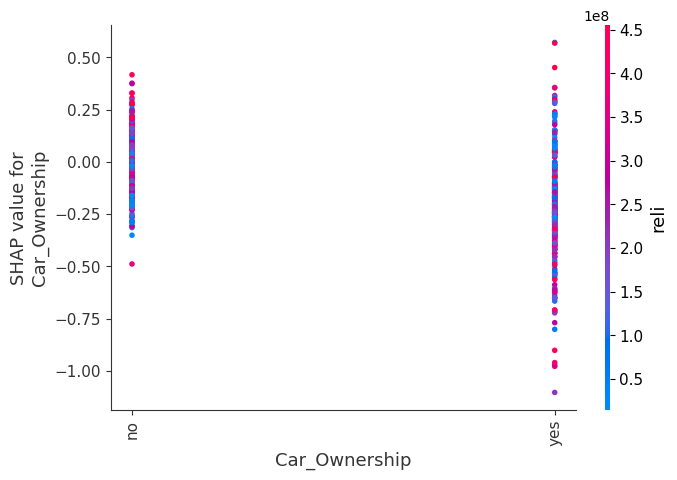

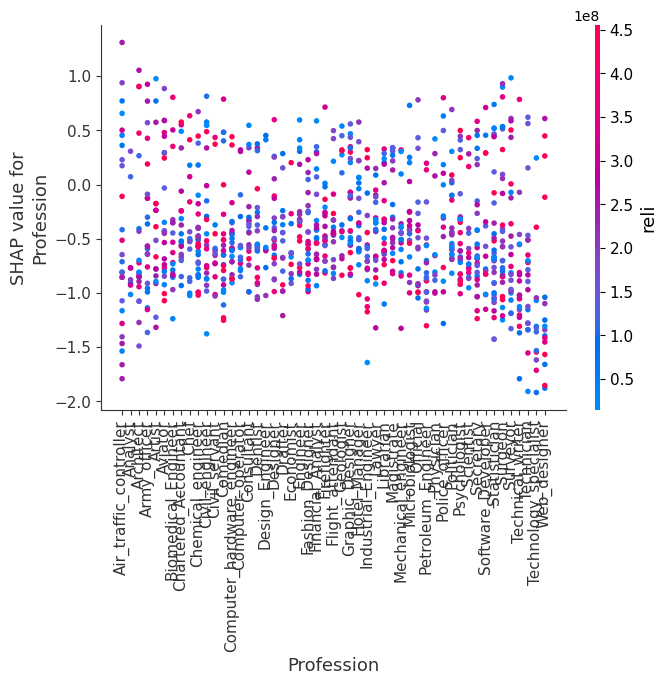

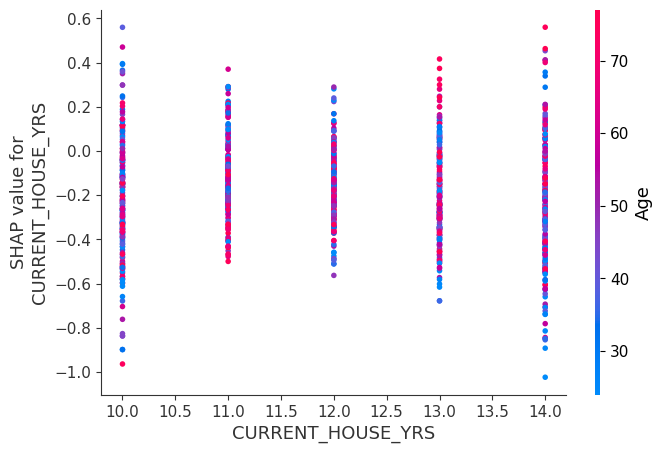

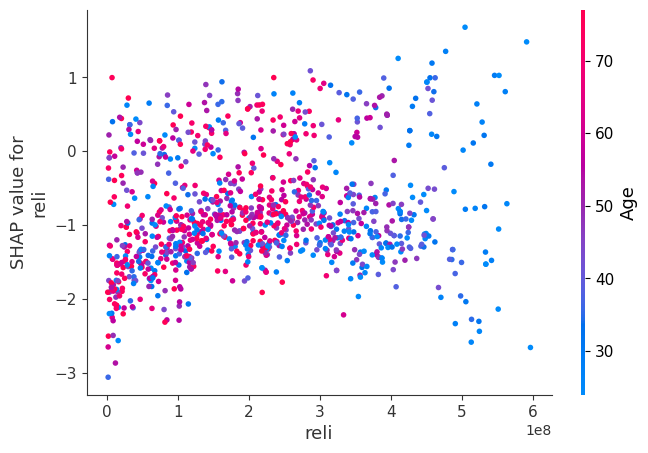

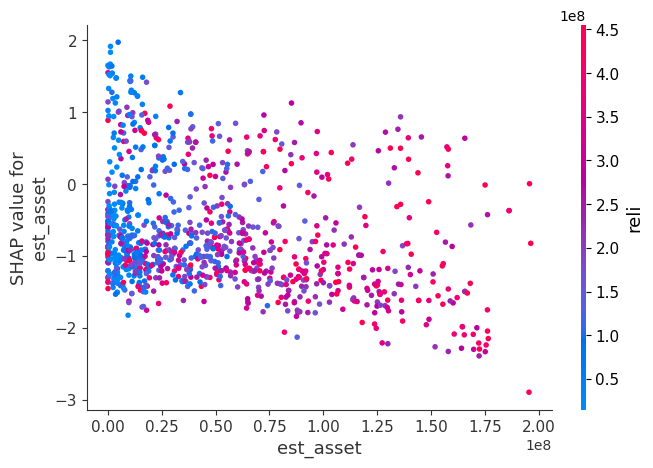

In [ ]:
shap.initjs()
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)


## PDP

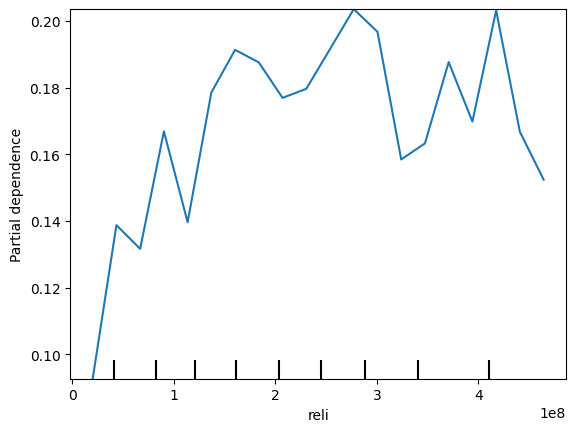

In [ ]:
from sklearn.inspection import plot_partial_dependence

features_to_plot = ['reli']
plot_partial_dependence(best_xgb, X_val, features_to_plot, grid_resolution=20);

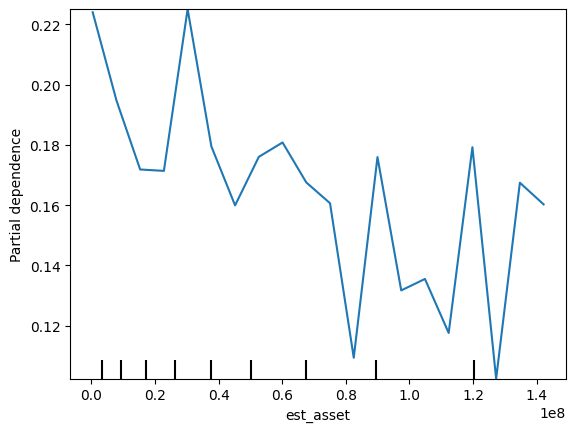

In [ ]:
from sklearn.inspection import plot_partial_dependence

features_to_plot = ['est_asset']
plot_partial_dependence(best_xgb, X_val, features_to_plot, grid_resolution=20);

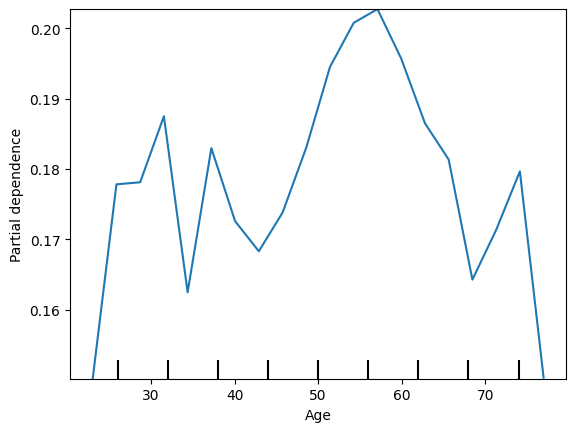

In [ ]:
features_to_plot = ['Age']
plot_partial_dependence(best_xgb, X_val, features_to_plot, grid_resolution=20);